# Using PLAYA-PDF to extract simple figures as SVG

This is, obviously, not production-ready, but PLAYA-PDF makes it easy for you to extract simple figures as vector graphics from tagged PDFs.  This is thanks to the fact that PDF and SVG have equivalent languages for describing paths.  Let's see how this works!

First, import some basic things

In [1]:
import playa
import paves.image as pi
from IPython.display import SVG

Here is a sample document, created with LibreOffice and saved as a tagged PDF:

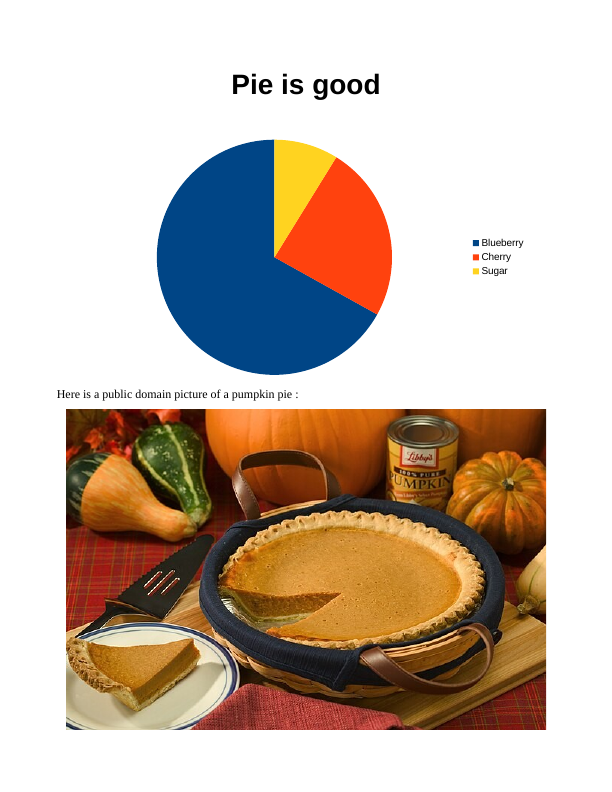

In [2]:
DOCUMENT = "../samples/pie.pdf"
pdf = playa.open(DOCUMENT)
page = pdf.pages[0]
pi.show(page)

## Finding a figure on a page with logical structure

Let's find the first figure on the page.  Since these come at you in logical (reading) order, we know that this is going to be the pie chart.  We can use PAVÉS to confirm that we got the right one:

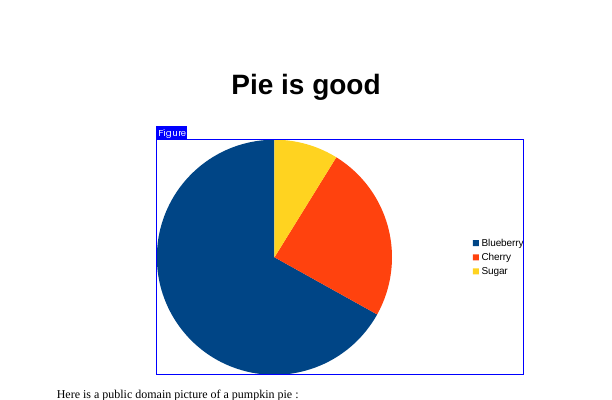

In [3]:
figure = page.structure.find("Figure")
pi.box(figure).crop((0, 0, 612, 400))

## Creating an SVG from the content objects in the figure

First, let's set up the size and view box of the SVG.  Everything here is going to be in device space, so we will simply use the page height and width, but we will use the `viewBox` to crop the actual image to the bounding box of the figure (this may or may not be specified in the logical structure, if not, you might want to pad it):

In [4]:
x0, y0, x1, y1 = figure.bbox
width = round(x1 - x0)
height = round(y1 - y0)
left = round(x0)
top = round(y0)
bbox = " ".join(str(x) for x in (left, top, width, height))
svg = [f"<svg version='1.1' width='{page.width}' height='{page.height}' viewBox='{bbox}'>"]

svg

["<svg version='1.1' width='612' height='792' viewBox='157 140 367 235'>"]

Now we can iterate over the contents of the figure in page order (here this isn't necessary, but it may be in the case where multiple contents overlap each other).  For each content object we will output an SVG element.

This is greatly facilitated by the fact that the SVG `M`, `L`, and `C` path operators are exactly the same as the PDF ones, just uppercased.  If we had encountered the PDF `v` or `y` operators, we'd have to add the implicit control point, but our figure doesn't have any of those.

For simplicity here, we won't actually support all of the graphics state, just what's actually in this image!

In [5]:
from playa.content import TextObject, PathObject
for c in figure.contents.page_order:
    for obj in c:
        if isinstance(obj, TextObject):
            x, y = obj.origin
            svg.append(f"<text x='{round(x)}' y='{round(y)}' font-size='{round(obj.size)}'>{obj.chars}</text>")
        elif isinstance(obj, PathObject):
            fcolor = f"rgb({' '.join(str(round(x * 255)) for x in obj.gstate.ncolor.values)})"
            program = []
            for seg in obj.segments:
                points = ", ".join(f"{round(x)} {round(y)}" for x, y in seg.points)
                program.append(f"{seg.operator.upper()} {points}")
            svg.append(f"<path stroke='none' fill='{fcolor}' d='{' '.join(program)}'/>")
svg.append("</svg>")
svg

["<svg version='1.1' width='612' height='792' viewBox='157 140 367 235'>",
 "<path stroke='none' fill='rgb(0 69 134)' d='M 274 140 C 262 140, 250 142, 238 145 C 226 149, 215 155, 205 162 C 195 169, 187 178, 179 188 C 172 198, 166 209, 163 221 C 159 233, 157 245, 157 257 C 157 270, 159 282, 163 294 C 166 305, 172 316, 179 326 C 187 336, 195 345, 205 352 C 215 360, 226 365, 238 369 C 250 373, 262 375, 274 375 C 287 375, 299 373, 311 369 C 322 365, 334 360, 344 352 C 354 345, 362 336, 370 326 C 372 323, 375 319, 377 314 L 274 257 L 274 257 L 274 257 L 274 257 L 274 257 L 274 257 L 274 257 L 274 257 L 274 257 L 274 257 L 274 257 L 274 257 L 274 257 L 274 257 L 274 257 L 274 140 H '/>",
 "<path stroke='none' fill='rgb(255 66 14)' d='M 377 314 C 381 308, 384 301, 386 294 C 390 282, 392 270, 392 257 C 392 245, 390 233, 386 221 C 382 209, 377 198, 370 188 C 362 178, 354 169, 344 162 C 341 160, 339 159, 336 157 L 274 257 L 274 257 L 274 257 L 274 257 L 274 257 L 274 257 L 274 257 L 377 314 H '/

And voilà... let's display it!  You'll notice that our pie isn't entirely round, because we rounded the coordinates above.  You probably shouldn't do that...

In [6]:
SVG("\n".join(svg))